In [8]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/ndd"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log"
aa = 277

277

In [5]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [6]:
function WeightedHist(in_vec::Array{Float64, 1}, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# NDD

In [9]:
# Leo nombres de structuras
tmp = readdlm(joinpath(home, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(joinpath(home, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(joinpath(home, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

mul = 10

## Leo volúmenes NDD y originales. Obtengo gradientes

In [29]:
# IM
im_each_vol = Array{Float64}(length(im_list))
im_each_ndd = Array{Float64}(aa_36, length(im_list))
im_each_der = Array{Float64}(aa_36, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]

    vol_filename = string("vol_", each)
    ndd_filename = string("out_ndd_", each)

    im_each_vol[i] = readdlm(joinpath(home, each, vol_filename))[1]
    im_each_ndd[:, i] = convert(Array{Float64, 1}, readdlm(joinpath(home, each, ndd_filename))[2:end, 2]);
    im_each_der[:, i] = (im_each_ndd[:, i] .- im_each_vol[i]) ./ mul
end


# ΑM
am_each_vol = Array{Float64}(length(am_list))
am_each_ndd = Array{Float64}(aa_36, length(am_list))
am_each_der = Array{Float64}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    vol_filename = string("vol_", each)
    ndd_filename = string("out_ndd_", each)

    am_each_vol[i] = readdlm(joinpath(home, each, vol_filename))[1]
    am_each_ndd[:, i] = convert(Array{Float64, 1}, readdlm(joinpath(home, each, ndd_filename))[2:end, 2]);
    am_each_der[:, i] = (am_each_ndd[:, i] .- am_each_vol[i]) ./ mul
end


In [58]:
# IM
im_each_der_norm = mapslices(x -> x ./ norm(x), im_each_der, 1)
# Me quedo con los modos 1 y 2
im_der_modo_1 = (im_each_der_norm[1, :]).^2
im_der_modo_2 = (im_each_der_norm[2, :]).^2

# AM
am_each_der_norm = mapslices(x -> x ./ norm(x), am_each_der, 1)
# Me quedo con los modos 1 y 2
am_der_modo_1 = (am_each_der_norm[1, :]).^2
am_der_modo_2 = (am_each_der_norm[2, :]).^2;

## Grafico

In [66]:
# 1
hbins = collect(minimum(im_der_modo_1):1e-3:maximum(im_der_modo_1))
hweights_im = repeat([1.0], inner = [length(im_der_modo_1)])
hweights_am = repeat([1.0], inner = [length(am_der_modo_1)])

counts_im, bins = WeightedHist(im_der_modo_1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(am_der_modo_1, hbins, hweights_am, true)


df_gdt_mode_1 = DataFrame(Probability = [counts_am ; counts_im],
    Gradient = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]))

# 2
hbins = collect(minimum(im_der_modo_2):1e-3:maximum(im_der_modo_2))
hweights_im = repeat([1.0], inner = [length(im_der_modo_2)])
hweights_am = repeat([1.0], inner = [length(am_der_modo_2)])

counts_im, bins = WeightedHist(im_der_modo_2, hbins, hweights_im, true)
counts_am, bins = WeightedHist(am_der_modo_2, hbins, hweights_am, true)


df_gdt_mode_2 = DataFrame(Probability = [counts_am ; counts_im],
    Gradient = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

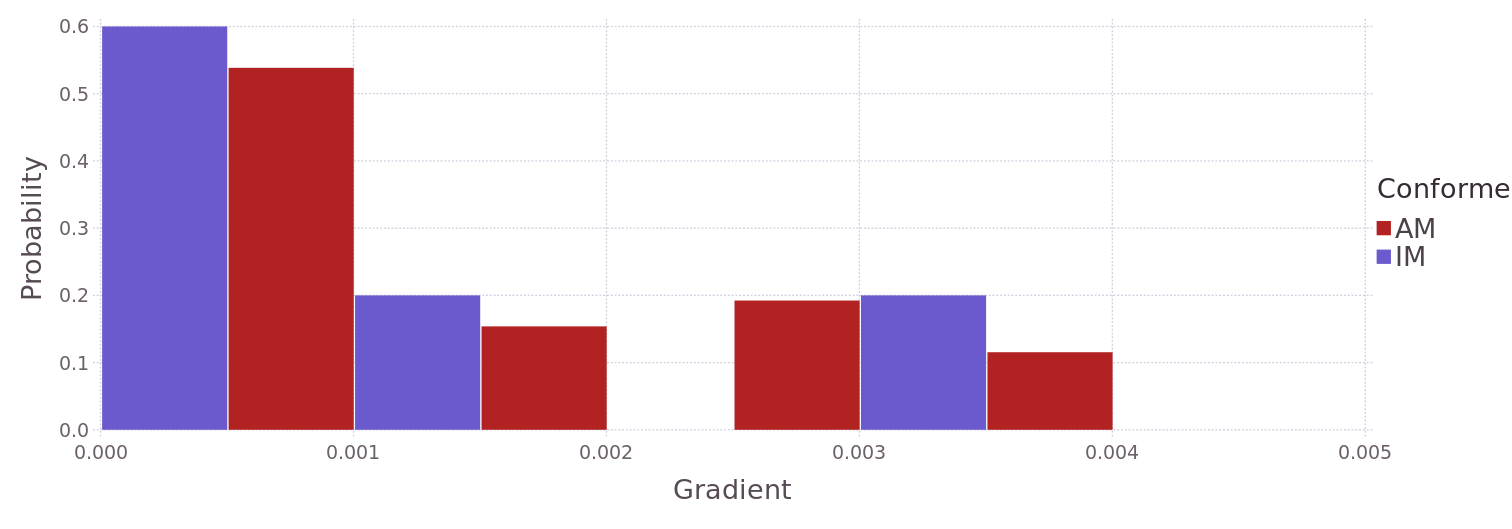

In [65]:
pdf_gdt_mode_1 = plot(df_gdt_mode_1, x="Gradient", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

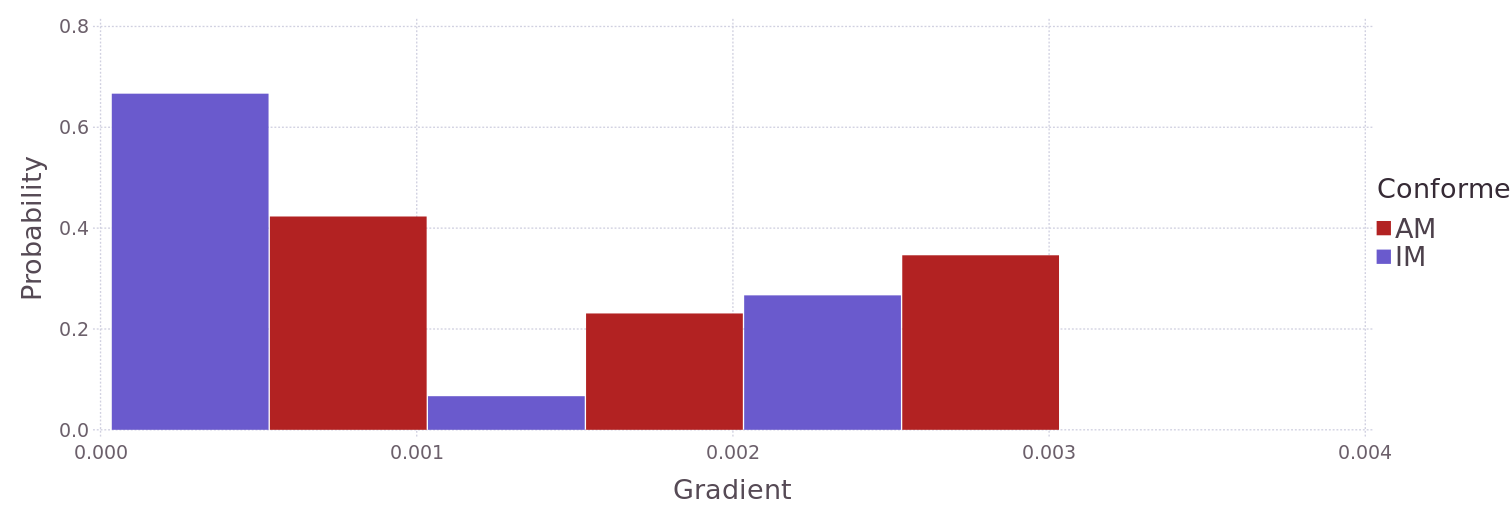

In [67]:
pdf_gdt_mode_2 = plot(df_gdt_mode_2, x="Gradient", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Guardo rtdos

In [64]:
writedlm(string(home_rtdos, "df_gdt_mode_1"), df_gdt_mode_1)
writedlm(string(home_rtdos, "df_gdt_mode_2"), df_gdt_mode_2)

# Gradientes
# IM
writedlm(string(home_rtdos, "im_der_modo_1"), im_der_modo_1)
writedlm(string(home_rtdos, "am_der_modo_1"), am_der_modo_1)
# AM
writedlm(string(home_rtdos, "im_der_modo_2"), im_der_modo_1)
writedlm(string(home_rtdos, "am_der_modo_2"), am_der_modo_2);